[*********************100%%**********************]  13 of 13 completed
Optimization Result: True
Optimization Message: Optimization terminated successfully
[*********************100%%**********************]  13 of 13 completed
Optimization Result: True
Optimization Message: Optimization terminated successfully
9.958066700026393
['70-30', 'No Constraints']


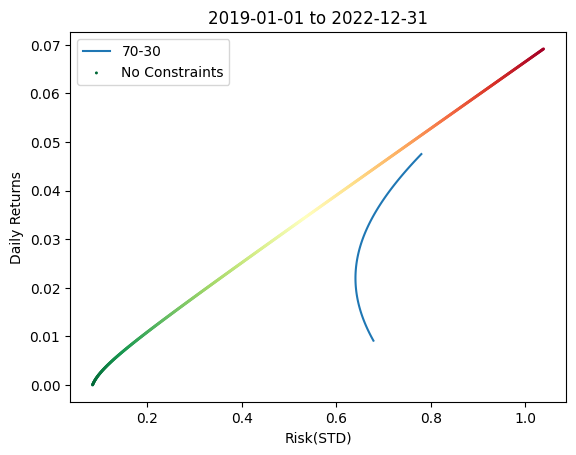

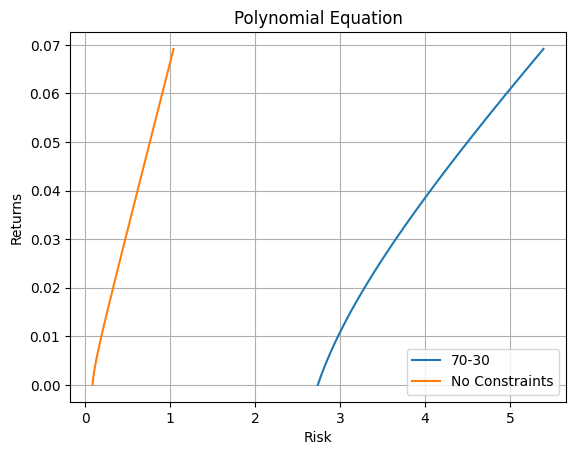

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
from openpyxl import load_workbook
import datetime
from matplotlib.backends.backend_pdf import PdfPages

#line 261 is where you can change the bounds to include shorting

"""
This function calculates the expected returns
 and log returns for a given stock ticker over a specified time frame. 
 The time frame can be optionally bounded using start and end dates.
"""
def calcreturns(ticker,time_frame,start = None, end = None):
    """
    This function calculates the expected return and log returns for a given stock.
    
    Parameters:
    ticker (str): The ticker symbol of the stock.
    time_frame (str): The period of time to consider for the return calculation.
    start (datetime, optional): The start date of the time frame.
    end (datetime, optional): The end date of the time frame.

    Returns:
    float: The expected return of the stock.
    np.array: The log returns of the stock.
    """
    tick = yf.Ticker(ticker)

    if start is None and end is None:
        
        dat = pd.DataFrame(tick.history(period=time_frame))
    else:
        dat = pd.DataFrame(tick.history(start=start, end = end))
    
    price_relative = []
    price_relative = np.array(np.zeros(len(dat)-2))
    for i in range(len(dat)-2):
        prior = dat['Close'][i]
        current = dat['Close'][i+1]
        price_relative[i] = current/prior
    returns1 = np.log(price_relative) * 100
    expected_returns = returns1.mean()
    return expected_returns, returns1


"""
This function computes the covariance matrix and returns for a 
list of stock tickers over a certain time frame. The time frame 
can be optionally bounded using start and end dates.
"""






def allto(stocks, timeframe, start=None, end=None):
    """
    This function retrieves stock data, calculates log returns, and generates a covariance matrix for a list of stocks.

    Parameters:
    stocks (list): A list of ticker symbols of the stocks.
    timeframe (str): The period of time to consider for the return calculation.
    start (datetime, optional): The start date of the time frame.
    end (datetime, optional): The end date of the time frame.

    Returns:
    DataFrame: The covariance matrix of the stocks' returns.
    np.array: The mean log returns of the stocks.
    float: The number of years of the time frame, calculated as the total number of trading days divided by 252.
    """
    for stock in stocks:
        if start is None:
            data = yf.download(stocks,period=timeframe)
        else:
            data = yf.download(stocks, start=start, end=end)
        if data.empty:
                print(f"No data found for {stock} in the specified time frame. Skipping this asset...")
                continue
        close_prices = data['Close']
        price_relative = close_prices / close_prices.shift(1)
        log_returns = np.log(price_relative).dropna() * 100
        num_years = len(log_returns) / 252  # approximate number of trading days in a year
        expected_returns = ((1 + log_returns.mean()/100)**252 - 1) * 100
        cov_matrix = log_returns.cov() 
        return cov_matrix, log_returns.mean(), num_years, log_returns.mean()

"""
This function computes the variance (risk) of a portfolio given a set of portfolio weights and a covariance matrix.
"""

def portfolio_variance(weights, cov_matrix):
    """
    This function calculates the variance of a portfolio given a covariance matrix and a vector of asset weights.

    Parameters:
    weights (np.array): The weights of the assets in the portfolio.
    cov_matrix (DataFrame): The covariance matrix of the assets' returns.

    Returns:
    float: The variance of the portfolio.
    """
    return np.dot(weights.T, np.dot(cov_matrix, weights))

"""
This function generates a set of weights for the assets in the portfolio. If specified, it can generate weights for a
 portfolio composed of stocks and bonds, with the portfolio weights for each group summing to certain specified amounts.
"""

def generate_portfolio_weights(num_bond, num_stock, bond_weight, stock_weight, unconstrained = False):
    """
    This function generates a set of portfolio weights for a specified number of portfolios and assets.

    Parameters:
    num_assets (int): The total number of assets.
    num_portfolios (int): The number of portfolios to generate.
    num_bond (int, optional): The number of bond assets in the portfolio.
    stock_weight (float, optional): The total weight of the stock assets in the portfolio.
    bond_weight (float, optional): The total weight of the bond assets in the portfolio.

    Returns:
    list: A list of portfolio weights.
    """
    if unconstrained is False:
        weights_matrix = []

        # Generate individual weights for bonds and stocks
        bond_weights = [bond_weight / num_bond] * num_bond
        stock_weights = [stock_weight / num_stock] * num_stock

        # Concatenate bond and stock weights
        weights = np.concatenate([bond_weights, stock_weights])
        weights_matrix.append(weights)
    else:
        weights_matrix = []
        weights = np.random.random(num_bond)
        weights /= np.sum(weights)
        weights_matrix.append(weights)

    return weights_matrix



"""
This function calculates the total return of a portfolio given a set of portfolio weights and the returns of the individual assets.
"""

def portfolio_return(weights, returns):
    """
    This function calculates the total return of a portfolio given a vector of asset weights and the individual asset returns.

    Parameters:
    weights (np.array): The weights of the assets in the portfolio.
    returns (np.array): The returns of the individual assets.

    Returns:
    float: The total return of the portfolio.
    """
    return np.dot(weights, returns)


"""
This function constructs the efficient frontier for a portfolio of the given stocks. 
It calculates the returns and volatilities for different portfolio weights and returns these values. 
The function can also include constraints on the portfolio, such as a maximum weight for bonds and stocks.
"""

def efficient_frontier(stocks, num_portfolios, timeframe,  security_type = None, stock_weight = None, bond_weight = None, start = None, end = None):
    """
    This function calculates the efficient frontier for a set of stocks. It generates a number of portfolios with 
    different weights, calculates the return and volatility of each portfolio, and returns these values.

    Parameters:
    stocks (list): A list of ticker symbols of the stocks.
    num_portfolios (int): The number of portfolios to generate.
    timeframe (str): The period of time to consider for the return calculation.
    security_type (list, optional): A list of the types of the assets in the portfolio (e.g., "Bond", "Stock").
    stock_weight (float, optional): The total weight of the stock assets in the portfolio.
    bond_weight (float, optional): The total weight of the bond assets in the portfolio.
    start (datetime, optional): The start date of the time frame.
    end (datetime, optional): The end date of the time frame.

    Returns:
    list: The volatilities of the portfolios.
    list: The returns of the portfolios.
    list: The weights of the portfolios.
    list: The coefficients used in the calculation of the efficient frontier.
    """
    if stock_weight is not None: 
        security_type.sort()
        num_bond = security_type.count("Bond")
        weights_matrix = generate_portfolio_weights(num_bond, len(stocks)-num_bond, bond_weight, stock_weight)
        cov_matrix, stockreturns, num_years, regreturns = allto(stocks, timeframe,start,end)
        r = np.array(regreturns)
        #print(r)
        weights = weights_matrix[0]
        V = cov_matrix
        temp = [bond_weight] * num_bond + [stock_weight] * (len(stocks) - num_bond)
        temp = temp
        temp = np.array(temp)
        #HERE
        r_p = r * weights
        var_p = temp @ V @ temp.T
        e = np.ones(r.shape)
        V_inv = np.linalg.inv(V)
        #print(r_p)  
         # Use r_p in place of e
        num_stocks = len(stocks) - num_bond
        weights = [bond_weight/num_bond] * num_bond + [stock_weight/num_stocks] * num_stocks
        weights = np.array(weights)

        # Apply weights to the returns and to the inverse covariance matrix
        r_p = r
        V_inv = V_inv * weights[:, None]

        A = weights.T @ V_inv @ weights
        B = r_p.T @ V_inv @ weights
        C = r_p.T @ V_inv @ r_p

    else:
        weights_matrix = generate_portfolio_weights(len(stocks), None,None,None,True)
        cov_matrix, stockreturns, num_years, regreturns = allto(stocks, timeframe,start,end)
        r = np.array(regreturns)
        r_p =  r   
        e = np.ones(r.shape)
        V_inv = np.linalg.inv(cov_matrix)  
        
        A = e.T @ V_inv @ e
        B = r_p.T @ V_inv @ e
        C = r_p.T @ V_inv @ r_p
    efficient_portfolio_returns = []
    efficient_portfolio_volatilities = []
    efficient_portfolio_weights = []
    reg_volatilities = []
    coeff = [A,B,C]
    #Weighted constraints
    if stock_weight is not None:
        cons = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, stockreturns) - target},   
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: np.sum(x[:num_bond]) - bond_weight},  
                #{'type': 'eq', 'fun': lambda x: np.sum(x[num_bond:]) - stock_weight}
                )
        min_return = min(stockreturns[:num_bond]) * bond_weight + min(stockreturns[num_bond:]) * stock_weight
        max_return = max(stockreturns[:num_bond]) * bond_weight + max(stockreturns[num_bond:]) * stock_weight
        target_returns = np.linspace(min_return,max_return,num_portfolios)
        #target_returns = np.linspace(min(stockreturns),  max(stockreturns), num_portfolios)
    #Uncpnstrained constraints
    else:
        cons = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, stockreturns) - target},   
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                #{'type': 'ineq', 'fun': lambda x: portfolio_return(x, returns)}
                )
        
        target_returns = np.linspace(min(stockreturns), max(stockreturns), num_portfolios)
    for target in target_returns:
        #HERE when bounds is None model includes shorting
        bounds = tuple((0, 1) for asset in range(len(stocks)))
        result = minimize(portfolio_variance, weights_matrix[0], args=(cov_matrix,), method='SLSQP', bounds=None, constraints=cons, options={'maxiter': 100000, 'ftol': 1e-9})
        if target > 0:
            efficient_portfolio_returns.append(target)
            efficient_portfolio_volatilities.append(np.sqrt(result['fun']))
            efficient_portfolio_weights.append(result['x'])
            reg_volatilities.append(result['fun'])
    print("Optimization Result:",result.success)
    print("Optimization Message:",result.message)
    if stock_weight is None:
        return efficient_portfolio_volatilities, efficient_portfolio_returns, efficient_portfolio_weights, coeff, regreturns, reg_volatilities
    else:
        return efficient_portfolio_volatilities, efficient_portfolio_returns, efficient_portfolio_weights, coeff, regreturns, reg_volatilities


"""
This function uses the efficient_frontier() function to construct efficient frontiers for
 a portfolio under different constraints. It then plots these frontiers on a graph.
"""

def graphit(portfolios,stocks, security_type, time_frame, noconstraints = False, start = None, end = None, rolling = False, port_bond=None, port_stock=None):
    """
    This function generates efficient frontiers for a portfolio under different constraints and plots these frontiers.

    Args:
    portfolios (int): The number of portfolios to be generated.
    stocks (list): A list of ticker symbols representing the assets within the portfolio.
    security_type (list): A list defining the type of each security within `stocks`.
    time_frame (str): The time period for which the data will be considered.
    noconstraints (bool, optional): If True, the portfolio is constructed without constraints. Defaults to False.
    start (str, optional): The start date for calculating the efficient frontier. Defaults to None.
    end (str, optional): The end date for calculating the efficient frontier. Defaults to None.
    rolling (bool, optional): If True, a rolling efficient frontier is calculated. Defaults to False.
    port_bond (float, optional): The weight of bonds in the portfolio. Defaults to None.
    port_stock (float, optional): The weight of stocks in the portfolio. Defaults to None.
    
    Returns:
    list: List of coefficients, returns, and title.
    """
    start1 = time.perf_counter()
    coeff_list = []
    returns_coeff = []
    if rolling == True:
        weights = np.random.random(len(stocks))
        weights = [1/len(stocks)] * len(stocks)
        if noconstraints is False:
            x1, y1, w1, coeff, r1, v1 = efficient_frontier(stocks, portfolios, time_frame, security_type,port_stock,port_bond,start,end)
        else:
            x1, y1, w1, coeff, r1, v1 = efficient_frontier(stocks, portfolios, time_frame, security_type,None,port_bond,start,end)
        plt.plot(x1,y1,label = start)
        if noconstraints is False:
            title = str(port_stock)+"-"+str(port_bond)+" over " +str(time_frame)
        else:
            title = "Unconstrained over " +str(time_frame)
        plt.title(title)
        returns = r1
        plt.legend()
    else:
        figure1 = plt.figure()
        writer = pd.ExcelWriter('portfolio_weights.xlsx', engine='openpyxl')
        weights = np.random.random(len(stocks))
        weights = [1/len(stocks)] * len(stocks)
        z = weights
        bondcount = security_type.count("Bond")
        colors = []

        # Define the configurations for the efficient frontier
        configs = [
            #{"alpha": 0, "beta": 1, "sheet_name": '0-100', "label": "0-100", "plot": True},
            # {"alpha": 0.55, "beta": 0.45, "sheet_name": '55-45', "label": "55-45", "plot": True},
            # {"alpha": 0.60, "beta": 0.40, "sheet_name": '60-40', "label": "60-40", "plot": True},
            # {"alpha": 0.4, "beta": 0.6, "sheet_name": '40-60', "label": "40-60", "plot": True},
            # {"alpha": 0.5, "beta": 0.5, "sheet_name": '50-50', "label": "50-50", "plot": True},
            {"alpha": 0.7, "beta": 0.3, "sheet_name": '70-30', "label": "70-30", "plot": True},
            {"alpha": None, "beta": None, "sheet_name": 'No Constraints', "label": "No Constraints", "plot": False, "portfolios_multiplier": 10},
            #{"alpha": 1, "beta": 0, "sheet_name": '100-0', "label": "100-0", "plot": True},
        ]
        coeff_list = []
        returns_coeff = []
        labels = []
        for config in configs:
            labels.append(config["label"])
            alpha, beta, sheet_name, label, plot = config["alpha"], config["beta"], config["sheet_name"], config["label"], config["plot"]
            portfolios_multiplier = config.get("portfolios_multiplier", 1)

            x, y, w, coeff, r1, v1 = efficient_frontier(stocks, portfolios * portfolios_multiplier, time_frame, security_type, alpha, beta, start, end)
            #print(np.polyfit(x,y,2))
            returns_coeff.append(r1)
            coeff_list.append(np.polyfit(x,y,2))
            df = pd.DataFrame(w, columns=stocks)
            df['Returns'] = y
            df['Risk'] = x
            df['regreturn'] = r1
            df['regvol'] = v1
            df.to_excel(writer, sheet_name=sheet_name)

            if plot:
                plt.plot(x, y, label=label)
                
            if sheet_name == 'No Constraints':
                for i in w:
                    colors.append(np.sum(i[:bondcount]))
                plt.scatter(x, y, label=label, c=colors, marker=".", cmap="RdYlGn", s=5)
        # Close the Pandas Excel writer and output the Excel file
        writer._save()
        end1 = time.perf_counter()
        print(end1-start1)
        """
        sp500 = yf.download("^GSPC", start=start, end=end)
        sp500_price_relative = sp500['Close'] / sp500['Close'].shift(1)
        sp500_log_returns = np.log(sp500_price_relative).dropna() * 100
        sp500_annual_returns = ((1 + sp500_log_returns.mean()/100)**252 - 1) * 100
        sp500_annual_volatility = sp500_log_returns.std() * np.sqrt(252)
        plt.scatter(sp500_annual_volatility, sp500_annual_returns, color='red', label='S&P 500')
        spy = yf.download("SPY", start=start, end=end)
        spy_price_relative = spy['Close'] / spy['Close'].shift(1)
        spy_log_returns = np.log(spy_price_relative).dropna() * 100
        spy_annual_returns = ((1 + spy_log_returns.mean()/100)**252 - 1) * 100
        spy_annual_volatility = spy_log_returns.std() * np.sqrt(252)
        plt.scatter(spy_annual_volatility, spy_annual_returns, color='blue', label='SPY')
        agg = yf.download("AGG", start=start, end=end)
        agg_price_relative = agg['Close'] / agg['Close'].shift(1)
        agg_log_returns = np.log(agg_price_relative).dropna() * 100
        agg_annual_returns = ((1 + agg_log_returns.mean()/100)**252 - 1) * 100
        agg_annual_volatility = agg_log_returns.std() * np.sqrt(252)
        plt.scatter(agg_annual_volatility, agg_annual_returns, color='green', label='AGG')
        """
        if start is None:
            plt.title(time_frame)
        else:
            title = start+" to "+end
            plt.title(title)
        
        t = datetime.datetime.now()
        title+= str(t) + ".pdf"
        title = title.replace(" ","_")
        title = title.replace("-","_")
        title = title.replace(":","_")
        plt.xlabel("Risk(STD)")
        plt.ylabel("Daily Returns")
        plt.legend()
        #plt.savefig(title,format="pdf")
        #plt.show()
    if rolling is True:
        return coeff, returns, title
    else:
        return coeff_list, returns_coeff, labels



def rolling(start, end, windowsize, bond,stock,unconstrained = False):
    """
    This function generates efficient frontiers on a rolling basis over a specified window size using the `graphit` function.

    Args:
    start (str): The start date for calculating the rolling efficient frontiers.
    end (str): The end date for calculating the rolling efficient frontiers.
    windowsize (int): The size of the rolling window in years.
    bond (float): The weight of bonds in the portfolio.
    stock (float): The weight of stocks in the portfolio.
    unconstrained (bool, optional): If True, the portfolio is constructed without constraints. Defaults to False.

    Returns:
    list: List of coefficients, returns, and labels.
    """
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    assets = ["TLT","AGG","SHY","XLP","XLE","XOP","XLY","XLF","XLV","XLI","XLB","XLK","XLU"]
    assettype = ["Bond","Bond","Bond","Stock","Stock","Stock","Stock","Stock","Stock","Stock","Stock","Stock","Stock"]
    window_size = windowsize  # years
    dates_range = pd.date_range(start_date, end_date, freq='YS') 
    #print(dates_range)
    coeff_list = []
    returns_list = []
    label_list = []
    fig1 = plt.figure()
    for current_year in dates_range:
        start = current_year - pd.DateOffset(years=window_size)
        end = current_year
        if start < start_date:
            continue
        start = start.strftime('%Y-%m-%d')
        end = end.strftime('%Y-%m-%d')
        #print(assettype)
        time_frame = str(window_size) + "y"
        if unconstrained is False:
            #x, y, z= graphit(100, assets, assettype, time_frame, True, start, end,True,bond,stock)
            x, y, z= graphit(100, assets, assettype, time_frame,False,start,end,True,bond,stock)
        else:
            x, y, z= graphit(100, assets, assettype, time_frame, True, start, end,True,bond,stock)
        label_list.append(start)
        coeff_list.append(x)
        returns_list.append(y)
    plt.xlabel("Risk(STD)")
    plt.ylabel("Return(Daily log returns)")
    plt.grid(True)
    if unconstrained is True:
        title = "unconstrained"
    else:
        title = time_frame
    t = datetime.datetime.now()
    title+= str(t) + ".pdf"
    title = title.replace(" ","_")
    title = title.replace("-","_")
    title = title.replace(":","_")
    #plt.savefig(title,format="pdf")
    #plt.show()
    return coeff_list, returns_list, label_list



def polynomial(coefficients, returns, label_list = None):
    """
    This function uses the coefficients of the efficient frontier to create a quadratic equation that represents the efficient frontier and plots this equation.

    Args:
    coefficients (list): A list of the coefficients of the quadratic equation for each efficient frontier.
    returns (list): A list of the returns of the portfolios on the efficient frontiers.
    label_list (list, optional): A list of labels for the efficient frontiers. Defaults to None.
    """
    print(label_list)
    fig2 = plt.figure()
    for i in range(len(coefficients)):
        #print(coefficients[i])
        r = np.linspace(0, max(returns[i]), 100)
        A = coefficients[i][0]
        B = coefficients[i][1]
        C = coefficients[i][2]
        # if C < 0:
        #     print("hit")
        #     C = 1
        y = (((A * r**2) - (2 * B * r) + C) / ((A * C) - B**2)) ** (1/2)
        #print(y[0])
        #y = A * r ** 2 + B * r + C
        if label_list is not None:
            plt.plot(y , r,label =label_list[i])
        else:
            plt.plot(y, r)
    plt.xlabel('Risk')
    plt.ylabel('Returns')
    plt.title('Polynomial Equation')
    plt.legend()
    plt.grid(True)
    #plt.show()



def save_image(filename):
    """
    This function saves a matplotlib figure as a PDF file.

    Args:
    filename (str): The name of the file in which the figure will be saved. The file will be saved in the current working directory.
    """
    p = PdfPages(filename)
    fig_nums = plt.get_fignums()  
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs: 
        fig.savefig(p, format='pdf') 
    p.close()  


assets = ["TLT","AGG","SHY","XLP","XLE","XOP","XLY","XLF","XLV","XLI","XLB","XLK","XLU"]
assettype = ["Bond","Bond","Bond","Stock","Stock","Stock","Stock","Stock","Stock","Stock","Stock","Stock","Stock"]
x, y, z = graphit(100,assets,assettype,"1y",True,"2019-01-01","2022-12-31")

#x, y, z= rolling("2015-01-01","2023-01-01",1,0.4,0.6,True)
polynomial(x,y,z)

filename = "multi_plot_image"  
t = datetime.datetime.now()
filename+= str(t) + ".pdf"
filename = filename.replace(" ","_")
filename = filename.replace("-","_")
filename = filename.replace(":","_")
# call the function
save_image(filename)